(60000, 28, 28)
number of classes: 10


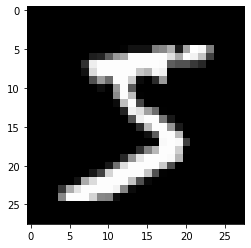

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
%matplotlib inline

# read mnist data from tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# scale pixels from [0,255] to [0,1]
x_train, x_test = x_train / 255, x_test / 255

print(x_train.shape)

# render an mnist image
plt.imshow(x_train[0], cmap='gray')

# number of classes
k = len(set(y_train))
print(f"number of classes: {k}")


Epoch 1/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3027 - accuracy: 0.9099 - val_loss: 0.1340 - val_accuracy: 0.9582
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1480 - accuracy: 0.9549 - val_loss: 0.1005 - val_accuracy: 0.9683
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1172 - accuracy: 0.9648 - val_loss: 0.0796 - val_accuracy: 0.9764
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0970 - accuracy: 0.9697 - val_loss: 0.0758 - val_accuracy: 0.9754
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0835 - accuracy: 0.9740 - val_loss: 0.0731 - val_accuracy: 0.9792
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0785 - accuracy: 0.9749 - val_loss: 0.0833 - val_accuracy: 0.9749
Epoch 7/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0699 - accuracy: 0.9773 - val_loss: 0.0712 - val_ac

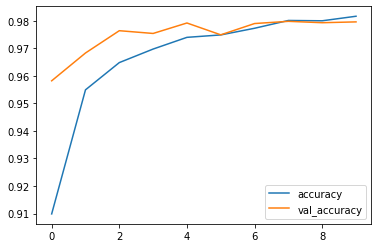

In [2]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
# double the num of feature maps with each conv layer:
x = Flatten()(i)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

# Compile and fit
# Note: GPU will help a lot here
metrics_list = ['accuracy']
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=metrics_list)

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10)
    
df_history = pd.DataFrame(history.history)
for metric in metrics_list:
    df_history[[metric, f'val_{metric}']].plot()


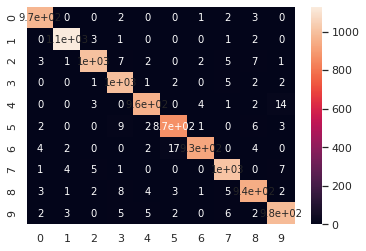

In [3]:
def plot_confusion_matrix(y, y_pred):
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y, y_pred))
    sns.set(font_scale=1.) # for label size
    sns.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 10}) # font size

def show_misclassified_example(x, y, y_pred):
    misclassified_mask = [y != y_pred]
    #print(y_misclassified)
    i = np.random.choice(x[misclassified_mask].shape[0])
    plt.imshow(x[misclassified_mask][i], cmap='gray')
    plt.show()
    print(f"y: {y[misclassified_mask][i]}\ny_pred: {y_pred[misclassified_mask][i]}")

y_test_pred = model.predict(x_test)
plot_confusion_matrix(y_test, np.argmax(y_test_pred, axis=1).astype('uint8'))


<ipython-input-3-fc9a6592ab6d>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  i = np.random.choice(x[misclassified_mask].shape[0])
<ipython-input-3-fc9a6592ab6d>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.imshow(x[misclassified_mask][i], cmap='gray')


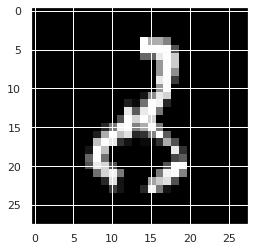

y: 8
y_pred: 2


<ipython-input-3-fc9a6592ab6d>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(f"y: {y[misclassified_mask][i]}\ny_pred: {y_pred[misclassified_mask][i]}")


In [4]:
show_misclassified_example(x_test, y_test, np.argmax(y_test_pred, axis=1).astype('uint8') )

In [5]:
model.summary() # show the model architecture

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290  

# CNN comparison just for fun

In [6]:
from tensorflow.keras.layers import Conv2D, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization

# read mnist data from tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# scale pixels from [0,255] to [0,1]
x_train, x_test = x_train / 255, x_test / 255

# the data is only 2D!
# convolution expects height x width x color
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

#******************************************
#   Model (fit without data augmentation)
#******************************************
i = Input(shape=x_train[0].shape)
# double the num of feature maps with each conv layer:
# do NOT use strided conv bc normal conv+maxpool works better here. Ref: VGG network (multiple conv before pooling)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
## conv group 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i) # need padding='same' to avoid shrinking image after each conv
x = BatchNormalization()(x) # BatchNormalization acts as a regularizer since mu and sigma change w/ each batch
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x) # Dropout didn't help with this dataset, so leave out
## conv group 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x) # Dropout didn't help with this dataset, so leave out
## conv group 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x) # Dropout didn't help with this dataset, so leave out
## Dense group
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(k, activation='softmax')(x)

model = Model(i, x)


(60000, 28, 28, 1)


In [7]:
# Compile
# Note: GPU will help a lot here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Fit
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=2)

Epoch 1/2
1875/1875 [==============================] - 964s 514ms/step - loss: 0.1349 - accuracy: 0.9631 - val_loss: 0.0570 - val_accuracy: 0.9846
Epoch 2/2
1875/1875 [==============================] - 942s 502ms/step - loss: 0.0581 - accuracy: 0.9835 - val_loss: 0.0538 - val_accuracy: 0.9844


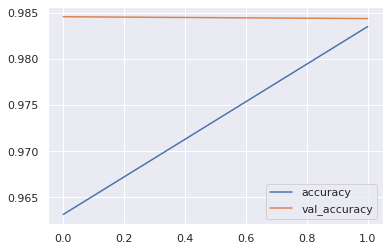

In [8]:
df_history = pd.DataFrame(history.history)
for metric in ['accuracy']:
    df_history[[metric, f'val_{metric}']].plot()

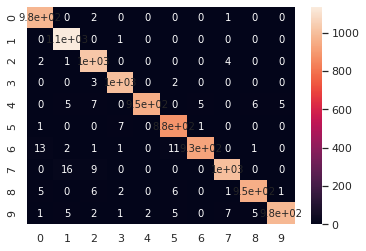

In [9]:
y_test_pred = model.predict(x_test)
plot_confusion_matrix(y_test, np.argmax(y_test_pred, axis=1).astype('uint8'))

<ipython-input-3-fc9a6592ab6d>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  i = np.random.choice(x[misclassified_mask].shape[0])
<ipython-input-3-fc9a6592ab6d>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.imshow(x[misclassified_mask][i], cmap='gray')


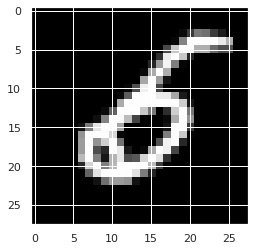

y: 5
y_pred: 6


<ipython-input-3-fc9a6592ab6d>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(f"y: {y[misclassified_mask][i]}\ny_pred: {y_pred[misclassified_mask][i]}")


In [10]:
show_misclassified_example(x_test.reshape(10000,28,28), 
                           y_test, 
                           np.argmax(y_test_pred, axis=1).astype('uint8') )